**1. Importing data set of images from GitHub repository**

In [1]:
!git clone https://github.com/chan4899/Gesture-Recognition.git # Will require access to internet

Cloning into 'Gesture-Recognition'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 99 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (99/99), done.


**2. Importing essential Python libraries and modules** 

In [2]:
import os
import glob
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

**3. Pre-proccessing image data set to obtain list of images with their labels**

In [3]:
dataset_path = "/content/Gesture-Recognition/dataset" # Store path where data set is saved
image_data = [] # Will store all images and their associated details in form of dictionary 
labels2name = ['','','',''] # Will store label name corresponding to assigned label index
for i, label in enumerate(os.listdir(dataset_path)): # 'dataset' folder has 4 folders, each having 1 class of images
    labelwise_image_path = os.path.join(dataset_path, label)
    images = glob.glob(os.path.join(labelwise_image_path, "*.jpg"))
    data = zip(images, [i]*len(images), [label]*len(images))
    for j in data: # Each folder for different classes will have several images
        labels2name[j[1]] = j[2] # Associates label name and label value
        image_dict = {'path': j[0], 'label': j[1], 'label_names': j[2]} # Image details stored in form of dictionary 
        image_data.append(image_dict) # Append image details to main list 

**4. Defining Hyperparameters**

In [4]:
# Defining seed so that the outputs across different devices remain the same
seed = 43
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# Defining Hyperparameters
epochs = 350 # Number of epochs
batch_size = 16 # Batch Size
lr = 0.01 # Learning Rate
weight_decay = 0.08 # Regularizing Parameter
image_size = 64 # Image Size

**5. Defining Class for Obtaining Data set as required by the Neural Model**

In [5]:
class GestureDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True):
        self.dataset_path = dataset_path
        self.train = train
        self.image_data = []
        for i, label in enumerate(os.listdir(dataset_path)):
            labelwise_image_path = os.path.join(dataset_path, label)
            images = glob.glob(os.path.join(labelwise_image_path, "*.jpg"))
            data = zip(images, [i]*len(images), [label]*len(images))
            for j in data:
                image_dict = {'path': j[0], 'label': j[1], 'label_names': j[2]}
                self.image_data.append(image_dict)
                
        self.transform = transforms.Compose([
                            transforms.Resize((image_size, image_size)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        random.seed(19)
        random.shuffle(self.image_data)
        if self.train:
            self.image_data = self.image_data[0:60]
        else:
            self.image_data = self.image_data[60:-1]

    def __getitem__(self, index):
        image_dict = self.image_data[index]
        img = Image.open(image_dict['path'])
        img = self.transform(img)
        return {'image': img, 'label': image_dict['label']}
        
    
    def __len__(self):
        return len(self.image_data)

**6. Storing Data set for Training and Testing**

In [6]:
train_dataset = GestureDataset(dataset_path, train=True)
test_dataset =  GestureDataset(dataset_path, train=False)

**7. Creating DataLoader Class for parallelizing the data loading process with the support of automatic batching**

In [7]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)
data = next(iter(train_dataloader))

**8. Defining Neural Network Model Parameters**

In [8]:
class NN_model(nn.Module):
    def __init__(self):
        super(NN_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=(3, 6), stride=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x)) # Convolutional Layer with ReLU activation
        x = self.relu(self.conv2(x)) # Convolutional Layer with ReLU activation
        x = self.relu(self.conv3(x)) # Convolutional Layer with ReLU activation
        x = self.conv4(x) # Output Layer
        x = x.view(x.shape[0], -1)
        return x

model = NN_model()
print(model)

NN_model(
  (conv1): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(8, 8, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(8, 8, kernel_size=(4, 4), stride=(2, 2))
  (conv4): Conv2d(8, 1, kernel_size=(3, 6), stride=(1, 1))
  (relu): ReLU()
)


**9. Defining Loss Functions and Optimizing Strategy**

In [9]:
# The model will use cross-entropy loss to train itself
criterion = nn.CrossEntropyLoss() 
loss = criterion(model(data['image']), data['label'])
# Implements Stochastic Gradient Descent 
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

**10. Training the Model**

In [10]:
losses = [] # Will store values of losses for each iteration for plotting
accuracy = [] # Will store accuracy values for each iteration for plotting
for i in range(epochs+1):
    iter_dataloader = iter(train_dataloader) # Loads data (dataset has size equal to batch size) to be used for training
    all_labels = [] # Will store true labels 
    all_preds = [] # Will store predicted label values
    for j in range(len(train_dataset)//batch_size):
        data = next(iter_dataloader)
        images = data["image"]
        labels = data["label"]
        
        preds = model(images) # Prediction of model
        loss = criterion(preds, labels) 
        
        # Backpropagation
        loss.backward() 
        optimizer.step() 
        optimizer.zero_grad() 
        losses.append(loss.data)
        
        all_labels.append(labels)
        all_preds.append(preds)
        
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    epoch_acc = accuracy_score(all_labels, torch.argmax(all_preds, axis=1).numpy()) # Calculates Accuracy
    epoch_pre = precision_recall_fscore_support(all_labels, torch.argmax(all_preds, axis=1).numpy()) # Calculates Precision, Recall, F Score and Support
    accuracy.append(epoch_acc)
    # Plotting Graphs at intervals of 10 epochs
    if i%10 == 0:
        print("Epoch", i, "Accuracy", epoch_acc, "Precision Recall Scores", epoch_pre)
        print("---------------------------------------------------------------------------------------------------")
    
data = next(iter(test_dataloader)) # Testing data set
images = data["image"]
labels = data["label"]

preds = model(images) # Prediction for Testing data set
pred_idx = torch.argmax(preds, axis=1).numpy()
test_acc = accuracy_score(labels, pred_idx) # Calculates Accuracy for Testing data set
# Display Outputs
print("Maximum train accuracy is", max(accuracy))
print("Final test accuracy is", test_acc)

Epoch 0 Accuracy 0.2916666666666667 Precision Recall Scores (array([0.21428571, 0.625     , 0.33333333, 0.        ]), array([0.6       , 0.33333333, 0.1875    , 0.        ]), array([0.31578947, 0.43478261, 0.24      , 0.        ]), array([10, 15, 16,  7]))
---------------------------------------------------------------------------------------------------
Epoch 10 Accuracy 0.4166666666666667 Precision Recall Scores (array([0.5       , 0.66666667, 0.30769231, 0.2       ]), array([0.8       , 0.375     , 0.26666667, 0.28571429]), array([0.61538462, 0.48      , 0.28571429, 0.23529412]), array([10, 16, 15,  7]))
---------------------------------------------------------------------------------------------------
Epoch 20 Accuracy 0.5833333333333334 Precision Recall Scores (array([0.66666667, 0.88888889, 0.4       , 0.5       ]), array([0.8       , 0.42105263, 0.5       , 0.85714286]), array([0.72727273, 0.57142857, 0.44444444, 0.63157895]), array([10, 19, 12,  7]))
---------------------------

**11. Plotting Graphs for Loss and Accuracy**

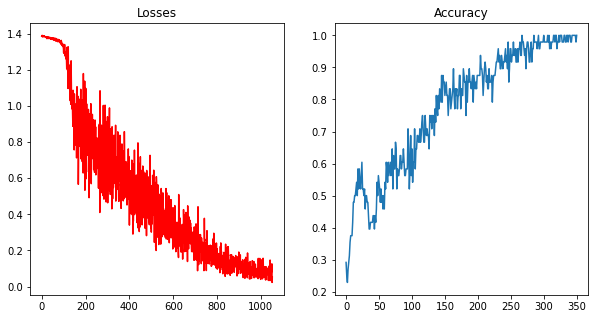

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, '-r')
plt.title("Losses")
plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(accuracy)
plt.show()

**12. Displaying Images with their True and Predicted Labels**

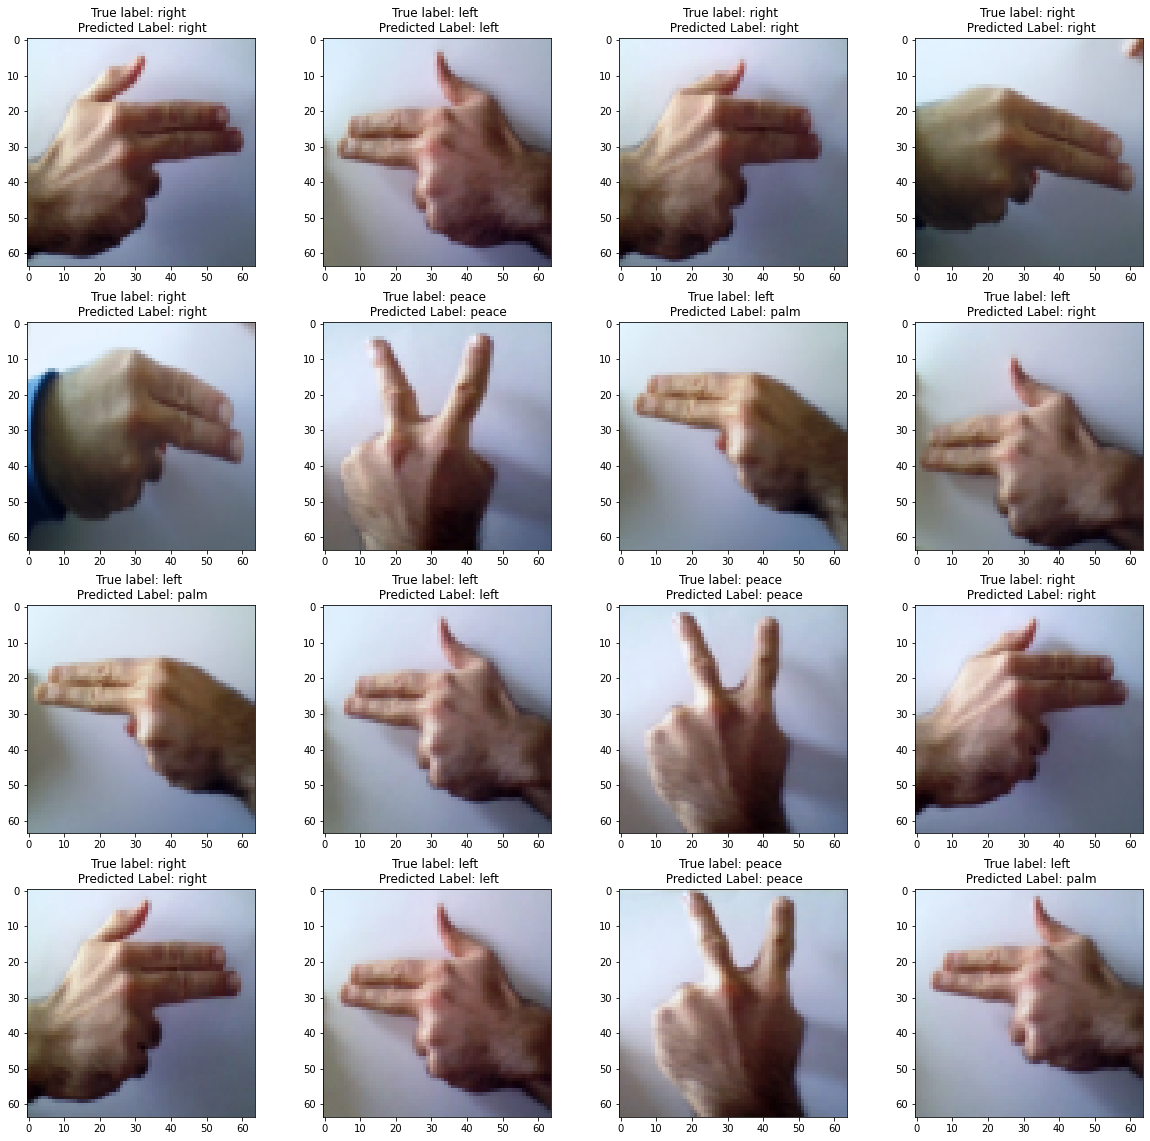

In [12]:
plt.figure(figsize=(20, 20))
for i in range(16):
  im = test_dataset[i]['image'].numpy().transpose(1, 2, 0)
  im = (im - im.min())/(im.max()-im.min())
  im = im*255
  im = im.astype('int32')
  plt.subplot(4, 4, i+1)
  plt.subplots_adjust(wspace=0.3)
  plt.imshow(im)
  plt.title("True label: {} \n Predicted Label: {}".format(labels2name[test_dataset[i]['label']], labels2name[pred_idx[i]]))
plt.show()

In [13]:
## Model is trained and results are displayed.